## KAGGLE(LOAD FILES)

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session



/kaggle/input/drug-interaction-and-smiles/interaction_list.csv
/kaggle/input/drug-interaction-and-smiles/drugIDandSMILES.csv


## COLAB(UPLOADING FILES)

In [ ]:
## UPLOAD THE TWO FILES
from google.colab import files
uploaded = files.upload()

Saving drugIDandSMILES.csv to drugIDandSMILES.csv
Saving interaction_list.csv to interaction_list.csv


## Installing the packages



In [1]:
! pip install rdkit-pypi
! pip install deepchem
# ! pip install dgl 
! pip install ogb

     |████████████████████████████████| 19.7 MB 35.6 MB/s 
     |████████████████████████████████| 552 kB 5.3 MB/s 
     |████████████████████████████████| 78 kB 3.5 MB/s 
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7048 sha256=52ad82f28855148df5bdd6a222ef1e91ccd55d4a97032411408b7e35b786ca13
  Stored in directory: /root/.cache/pip/wheels/d6/64/cd/32819b511a488e4993f2fab909a95330289c3f4e0f6ef4676d
Successfully built littleutils


In [2]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [3]:
! pip install dgl-cu111 -f https://data.dgl.ai/wheels/repo.html

Looking in links: https://data.dgl.ai/wheels/repo.html
     |████████████████████████████████| 164.7 MB 11 kB/s 


## Importing the required modules

In [4]:
import numpy as np
import pandas
import time
import networkx as nx
import itertools
import scipy.sparse as sp
import random 

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [6]:
from rdkit.Chem import MACCSkeys
from rdkit import Chem

In [7]:
import dgl
from dgl.nn import SAGEConv,GraphConv
import dgl.function as fn

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


Using backend: pytorch


In [8]:
from sklearn.metrics import roc_auc_score
from ogb.linkproppred import Evaluator

In [9]:
import copy

## Reading the files and saving the required columns in variables





In [10]:
csvFile = pandas.read_csv('./drugIDandSMILES.csv')
 
print(len(csvFile))
print(csvFile)

11160
       Drug ID                                             SMILES
0      DB00006  CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@...
1      DB00007  CCNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=N)NC(=...
2      DB00014  CC(C)C[C@H](NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H...
3      DB00027  CC(C)C[C@@H](NC(=O)CNC(=O)[C@@H](NC=O)C(C)C)C(...
4      DB00035  NC(=O)CC[C@@H]1NC(=O)[C@H](CC2=CC=CC=C2)NC(=O)...
...        ...                                                ...
11155  DB16400  [H][C@@]1(O[C@H](CO)[C@@H](O)[C@H](O)[C@@H]1O)...
11156  DB16403  [H][C@@]1(O[C@@H](OC2=C(OC3=C(C(O)=CC(O)=C3)C2...
11157  DB16404                             CC(C)C1=CC(O)=C(C)C=C1
11158  DB16406  CC1=C(C=C(S1)C(=O)C1=C(N[C@H]2C[C@H](O)[C@@H](...
11159  DB16408  COC1=NC(OC)=C2C(O[C@]3([C@@H]([C@@H](CN(C)C)[C...

[11160 rows x 2 columns]


In [11]:
drug_id = csvFile['Drug ID']
smiles = csvFile['SMILES']

In [12]:
csvFile = pandas.read_csv('./interaction_list.csv')
 
print(len(csvFile))
print(csvFile)

658269
       Drug1 ID Drug2 ID
0       DB00001  DB01323
1       DB00001  DB00346
2       DB00001  DB13783
3       DB00001  DB06605
4       DB00001  DB09075
...         ...      ...
658264  DB13929  DB12749
658265  DB13929  DB12771
658266  DB13929  DB13036
658267  DB13929  DB13400
658268  DB13929  DB13510

[658269 rows x 2 columns]


In [13]:
interaction_id1 = csvFile['Drug1 ID']
interaction_id2 = csvFile['Drug2 ID']

In [14]:
# print(smiles[0])

## Checking the USE of MACCS keys for encoding the SMILES 

In [15]:
# # Paper on MACCS keys: https://www.biorxiv.org/content/10.1101/853762v1.full.pdf

# molecular access system : (MACCS)

# MACCS keys are 166-bit 2D structure fingerprints that are commonly used for the 
# measure of molecular similarity. Because each bit is either on (i.e., 1) or 
# off (i.e., 0), MACCS 166 keys can represent more than 9.3 × 1049 distinct 
# fingerprint vectors

# CODE LINK: https://github.com/rdkit/rdkit-orig/blob/master/rdkit/Chem/MACCSkeys.py
# help(MACCSkeys.GenMACCSKeys)

In [16]:
# CHECKING THE MACCS ENCODINGS OF DIFFERENT MOLECULES

mol = Chem.MolFromSmiles(smiles[0])
# print(MACCSkeys.GenMACCSKeys(mol)) --> rdkit.DataStructs.cDataStructs.ExplicitBitVect object
print(list(MACCSkeys.GenMACCSKeys(mol)))
print(len(list(MACCSkeys.GenMACCSKeys(mol))))

mol2 = Chem.MolFromSmiles(smiles[1])
print(list(MACCSkeys.GenMACCSKeys(mol2)))
print(len(list(MACCSkeys.GenMACCSKeys(mol2))))

mol3 = Chem.MolFromSmiles(smiles[2])
print(list(MACCSkeys.GenMACCSKeys(mol3)))
print(len(list(MACCSkeys.GenMACCSKeys(mol3))))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
167
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [17]:
# print(smiles[0])
# print(list(smiles[0]))
# x=[]
# x.append(smiles[0])
# print(x)

## Common variable(s) and function(s) for all models

In [18]:
def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## FORMING THE GRAPH USING THE INTERACTIONS AS EDGES AND ENCODING THE SMILES AS FEATURES FOR THE NODES

In [20]:
drugbank_id_to_graph_node_id_map = {}
graph_node_id_to_drugbank_id_map = {}

drugs_with_smiles_list = set()

# to maintain the count of nodes in the graph
count = 0 

for x in drug_id:
#     print(x)
    drugbank_id_to_graph_node_id_map[x] = count
    graph_node_id_to_drugbank_id_map[count] = x
    drugs_with_smiles_list.add(x)
    count = count + 1
#     break

In [21]:
print(len(drugbank_id_to_graph_node_id_map))
print(len(graph_node_id_to_drugbank_id_map))
print(len(drugs_with_smiles_list))
print(len(smiles))

11160
11160
11160
11160


In [22]:
%%time 
# For the drugs_with_smiles_list, using the set(set()) inplace of list([])
# reduces the time consumed from 2 min 9 sec to 10.9 sec
num_interactions = len(interaction_id1)
# print(num_interactions)
u = []
v = []
for i in range(num_interactions):
    if interaction_id1[i] in drugs_with_smiles_list and interaction_id2[i] in drugs_with_smiles_list:
#         print(interaction_id1[i], interaction_id2[i])
#         break
        u.append(drugbank_id_to_graph_node_id_map[interaction_id1[i]])
        v.append(drugbank_id_to_graph_node_id_map[interaction_id2[i]])

CPU times: user 9.53 s, sys: 21.9 ms, total: 9.55 s
Wall time: 9.58 s


In [23]:
print(len(interaction_id1))
print(len(u))
print(len(v))

658269
583548
583548


In [24]:
print(len(drugs_with_smiles_list))
no_nodes = len(drugs_with_smiles_list)

11160


In [25]:
g = dgl.DGLGraph()
g.add_nodes(no_nodes)

/usr/local/lib/python3.7/dist-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


In [26]:
g.add_edges(u,v)

In [27]:
print(g)
print(u[0], v[0])
for t1,t2 in zip(u,v):
  if t1 == v[0] and t2 == u[0]:
    print(t1,t2)
    print("found")
    break

Graph(num_nodes=11160, num_edges=583548,
      ndata_schemes={}
      edata_schemes={})
0 240
240 0
found


In [28]:
%%time
# to find out if there are unidirectional edges(and, the edges themselves)
edges_as_set = set()
new_edges_to_be_added = 0
for _ in zip(u,v):
  edges_as_set.add(_)
for (t2,t1) in zip(v,u):
  flag = 0
  if (t2,t1) not in edges_as_set:
    print(t2,t1)
    # g.add_edges([t2],[t1])
    new_edges_to_be_added+=1
    ## REMOVE THE break STATEMENT NEXT LINE TO FIND TOTAL EDGES TO BE ADDED
    break

# print(new_edges_to_be_added)

# A more time consuming approach for the same task
# index_count = 0
# new_edges_added = 0
# for t1,t2 in zip(u,v):
#   flag = 0
#   for t3,t4 in zip(u,v):
#     if t3 == t2 and t4 == t1:
#       flag =1
#       break
#   if flag == 0:
#     g.add_edges([t2],[t1])
#     new_edges_added+=1

# print(new_edges_added)

7815 0
CPU times: user 175 ms, sys: 37.2 ms, total: 212 ms
Wall time: 212 ms


In [29]:
# MAKING THE GRAPH A BIDIRECTIONAL ONE BY ADDING REVERSE EDGES 
# # g.add_edges(v,u)
print(g.num_edges())
print(g.num_nodes())
n1 = g.num_edges()
g = dgl.add_reverse_edges(g)
n2 = g.num_edges()
print(n2/n1)
print(g.num_edges())
print(g.num_nodes())

583548
11160
2.0
1167096
11160


In [30]:
# CHECK A FEW EDGES TO VERIFY THAT THE EDGES ARE EXTRACTED 
# PROPERLY FROM THE CSV FILE TO THE DGL GRAPH
print(u[0], v[0])
# print(v[0])
print(u[1], v[1])
print(graph_node_id_to_drugbank_id_map[u[0]], graph_node_id_to_drugbank_id_map[v[0]])
print(graph_node_id_to_drugbank_id_map[u[1]], graph_node_id_to_drugbank_id_map[v[1]])
temp_count = 0
for i in range(num_interactions):
    if interaction_id1[i] in drugs_with_smiles_list and interaction_id2[i] in drugs_with_smiles_list:
        print(interaction_id1[i], interaction_id2[i])
        temp_count = temp_count + 1
        if temp_count == 2:
            break

0 240
0 9715
DB00006 DB00346
DB00006 DB13783
DB00006 DB00346
DB00006 DB13783


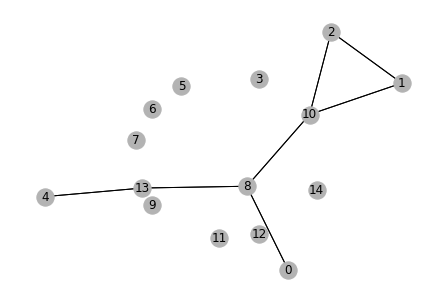

In [31]:
# Extract a sub graph and view it
sg1 = g.subgraph([0,1,2,3,4,5,6,7,8,9,10,15,67,89,90])
# using networkx to view it 
# Since the actual graph is undirected, we convert it for visualization purpose
nx_G = sg1.to_networkx().to_undirected()
pos = nx.kamada_kawai_layout(nx_G)
nx.draw(nx_G, pos, with_labels=True, node_color=[[.7, .7, .7]])

In [32]:
# from rdkit.Chem import MACCSkeys
# from rdkit import Chem

mol = Chem.MolFromSmiles(smiles[0])
print(list(MACCSkeys.GenMACCSKeys(mol)))
MACCSkeys_length = len(list(MACCSkeys.GenMACCSKeys(mol)))
print(MACCSkeys_length)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
167


In [33]:
# tensor1 = torch.zeros(3,3)
# print(tensor1[0])
# tensor1[0] = torch.Tensor([1,2,3])
# print(tensor1)

In [34]:
%%time
# CREATING THE NODE EMBEDDINGS

MACCSkeys_features = torch.zeros(g.num_nodes(), MACCSkeys_length)
# LIST TO CAPTURE THE MOLECULES THAT ARE NOT BEING ABLE TO ENCODED AS MACCS_KEYS
molecules_with_no_MACCS_keys = []

for i in range(g.num_nodes()):
    mol = Chem.MolFromSmiles(smiles[i])
    try:
        MACCSkeys__ = list(MACCSkeys.GenMACCSKeys(mol))
        MACCSkeys_features[i] = torch.Tensor(MACCSkeys__)
    except:
        print(drug_id[i])
        molecules_with_no_MACCS_keys.append(drug_id[i])

DB00515
DB00526
DB00958
DB01999
DB11630
DB13145
CPU times: user 18.1 s, sys: 851 ms, total: 18.9 s
Wall time: 18.6 s


In [35]:
g.ndata['feat'] = MACCSkeys_features

In [36]:
### SELF LOOPS ARE ESSENTIAL TO ENSURE THAT NODES WITH NO INCOMING EDGES 
### FROM OTHER NODES DO NOT LOSE THEIR FEATURES

### SKIP THIS CELL

# If you don't add self loops for all the nodes, atleast do it 
# for the last node, to maintain parity in dimensions. 
# For the last node, there is no edge arising from it for the interactions, 
# and, hence, it goes missing, in the nodes with edges list. 
# print(g.num_edges())
# g.add_edges([no_nodes-1],[no_nodes-1])
# print(g.num_edges())

In [37]:
# ADDING SELF LOOPS FOR EACH OF THE NODES 
# TO ENSURE THAT THE FEATURES ARE NOT LOST FOR THE NODES WITH NO EDGES 
# ENTERING IT
print(g)
n1 = g.num_edges()
l1 = [i for i in range(no_nodes)]
g.add_edges(l1,l1)
# for i in range(no_nodes):
#   g.add_edge([i], [i])
n2 = g.num_edges()
print(n2 - n1)
print(g)

Graph(num_nodes=11160, num_edges=1167096,
      ndata_schemes={'feat': Scheme(shape=(167,), dtype=torch.float32)}
      edata_schemes={})
11160
Graph(num_nodes=11160, num_edges=1178256,
      ndata_schemes={'feat': Scheme(shape=(167,), dtype=torch.float32)}
      edata_schemes={})


In [38]:
# g = g.to(device)

## Training, Evaluation and Testing sets in the ratio of 70:10:20

In [39]:
u, v = g.edges()

print(len(u))

eids = np.arange(g.number_of_edges())
eids = np.random.permutation(eids)
test_size = int(len(eids) * 0.2)
val_size = int(len(eids) * 0.1)
train_size = g.number_of_edges() - test_size - val_size
test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
val_pos_u, val_pos_v = u[eids[test_size:(test_size+val_size)]], v[eids[test_size:(test_size+val_size)]]
train_pos_u, train_pos_v = u[eids[(test_size+val_size):]], v[eids[(test_size+val_size):]]

print(test_size, val_size, train_size)
print(len(test_pos_u), len(test_pos_v))
print(len(val_pos_u), len(val_pos_v))
print(len(train_pos_u), len(train_pos_v))

1178256
235651 117825 824780
235651 235651
117825 117825
824780 824780


In [40]:
# Find all negative edges and split them for training and testing
adj = sp.coo_matrix((np.ones(len(u)), (u.numpy(), v.numpy())))
print(adj.shape)
adj_dense = adj.todense()
# REMOVE THE DUPLICATE EDGES
adj_dense = np.clip(adj_dense, a_min = 0, a_max = 1)

(11160, 11160)


In [41]:
# SINCE SELF LOOPS ARE ADDED, TO CREATE THE adj_neg, WE NO LONGER NEED 
# TO SUBTRACT THE np.eye(g.num_nodes()) in the next STATEMENT
# adj_neg = 1 - adj.todense() - np.eye(g.number_of_nodes())
adj_neg = 1 - adj_dense 
print(np.where(adj_dense>1))
print(np.where(adj_neg<0))
print(np.where(adj_neg>1))

(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))


In [42]:
neg_u, neg_v = np.where(adj_neg != 0)

neg_eids = np.random.choice(len(neg_u), g.number_of_edges())
test_neg_u, test_neg_v = neg_u[neg_eids[:test_size]], neg_v[neg_eids[:test_size]]
val_neg_u, val_neg_v = neg_u[neg_eids[test_size:(test_size + val_size)]], neg_v[neg_eids[test_size:(test_size + val_size)]]
train_neg_u, train_neg_v = neg_u[neg_eids[(test_size + val_size):(test_size + val_size+ train_size)]], neg_v[neg_eids[(test_size + val_size):(test_size + val_size+ train_size)]]


In [43]:
train_g = dgl.remove_edges(g, eids[:(test_size+val_size)])

In [44]:
train_g = train_g.to(device)

In [52]:
print(train_g)
print(train_g.ndata['feat'])

Graph(num_nodes=11160, num_edges=824780,
      ndata_schemes={'feat': Scheme(shape=(167,), dtype=torch.float32)}
      edata_schemes={})
tensor([[0., 0., 0.,  ..., 1., 1., 0.],
        [0., 0., 0.,  ..., 1., 1., 0.],
        [0., 0., 0.,  ..., 1., 1., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 1., 0.],
        [0., 0., 0.,  ..., 1., 1., 0.],
        [0., 0., 0.,  ..., 1., 1., 0.]], device='cuda:0')


In [45]:
# adding self loops 
# (THIS PROCESS IS REDUNDANT for the nodes in train_g that
# already have self loops, and hence, it introduces duplicacies, if we 
# reintroduce self loops)

# print(train_g)
# new_train_g_with_self_loops = dgl.add_self_loop(train_g)
# print(new_train_g_with_self_loops)
# print(new_train_g_with_self_loops.num_edges() - train_g.num_edges())

## MODEL: GRAPHSAGE **(Optimized the setup)**, METRIC: AUC, HITS

### MODEL AND PREDICTOR

In [46]:
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, 'mean')
        self.conv2 = SAGEConv(h_feats, h_feats, 'mean')

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

In [47]:
class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            return g.edata['score'][:, 0]

class MLPPredictor(nn.Module):
    def __init__(self, h_feats):
        super().__init__()
        self.W1 = nn.Linear(h_feats * 2, h_feats)
        self.W2 = nn.Linear(h_feats, 1)

    def apply_edges(self, edges):
        h = torch.cat([edges.src['h'], edges.dst['h']], 1)
        return {'score': self.W2(F.relu(self.W1(h))).squeeze(1)}

    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(self.apply_edges)
            return g.edata['score']

### TRAIN, VAL and TEST Graphs (POS AND NEG)

In [48]:
train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.number_of_nodes()).to(device)
train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.number_of_nodes()).to(device)

val_pos_g = dgl.graph((val_pos_u, val_pos_v), num_nodes=g.number_of_nodes()).to(device)
val_neg_g = dgl.graph((val_neg_u, val_neg_v), num_nodes=g.number_of_nodes()).to(device)

test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes()).to(device)
test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.number_of_nodes()).to(device)

### LOSS: BCE , METRIC: AUC, TRAIN THE GRAPH AND TEST

In [66]:
def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).to(device)
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).cpu().numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
    return roc_auc_score(labels, scores)

In [67]:
set_seed()

model = GraphSAGE(train_g.ndata['feat'].shape[1], 16).to(device)

#pred = MLPPredictor(16).to(device)
pred = DotPredictor().to(device)

In [68]:
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

best_val_auc = 0

all_logits = []
for e in range(200):
    # forward
    h = model(train_g, train_g.ndata['feat'])
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        pos_score = pred(val_pos_g, h)
        neg_score = pred(val_neg_g, h)
        val_auc = compute_auc(pos_score, neg_score)
    
    if best_val_auc < val_auc:
        best_val_auc = val_auc

    if e % 5 == 0:
        print('In epoch {}, loss: {:.3f}, val_auc: {:.3f}, best_val_auc: {:.3f}'.format(
            e, loss, val_auc, best_val_auc))
        
    # if e % 100 == 0:
    #     optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)
        

In epoch 0, loss: 20.142, val_auc: 0.773, best_val_auc: 0.773
In epoch 5, loss: 0.750, val_auc: 0.775, best_val_auc: 0.775
In epoch 10, loss: 0.697, val_auc: 0.627, best_val_auc: 0.775
In epoch 15, loss: 0.697, val_auc: 0.667, best_val_auc: 0.775
In epoch 20, loss: 0.696, val_auc: 0.602, best_val_auc: 0.775
In epoch 25, loss: 0.696, val_auc: 0.578, best_val_auc: 0.775
In epoch 30, loss: 0.696, val_auc: 0.586, best_val_auc: 0.775
In epoch 35, loss: 0.695, val_auc: 0.462, best_val_auc: 0.775
In epoch 40, loss: 0.695, val_auc: 0.441, best_val_auc: 0.775
In epoch 45, loss: 0.695, val_auc: 0.445, best_val_auc: 0.775
In epoch 50, loss: 0.695, val_auc: 0.448, best_val_auc: 0.775
In epoch 55, loss: 0.695, val_auc: 0.450, best_val_auc: 0.775
In epoch 60, loss: 0.694, val_auc: 0.451, best_val_auc: 0.775
In epoch 65, loss: 0.694, val_auc: 0.449, best_val_auc: 0.775
In epoch 70, loss: 0.694, val_auc: 0.450, best_val_auc: 0.775
In epoch 75, loss: 0.694, val_auc: 0.452, best_val_auc: 0.775
In epoch 

In [69]:
with torch.no_grad():
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    test_auc = compute_auc(pos_score, neg_score)

print(test_auc)

0.5380549744451388


### LOSS: BCE, METRIC: HITS@K, TRAIN THE GRAPH AND TEST

In [70]:

def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).to(device)
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_hits_k(pos_score, neg_score, K):
    y_pred_neg = neg_score
    y_pred_pos = pos_score
    if len(y_pred_neg) < K:
        return 1.

    kth_score_in_negative_edges = torch.topk(y_pred_neg, K)[0][-1]
    hitsK = float(torch.sum(y_pred_pos > kth_score_in_negative_edges).cpu()) / len(y_pred_pos)
    return hitsK

In [71]:
set_seed()

model = GraphSAGE(train_g.ndata['feat'].shape[1], 16).to(device)

#pred = MLPPredictor(16).to(device)
pred = DotPredictor().to(device)

In [72]:
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

best_val_hits_k = -float('inf')

k_hits = 20

all_logits = []
for e in range(200):
    # forward
    h = model(train_g, train_g.ndata['feat'])
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        pos_score = pred(val_pos_g, h)
        neg_score = pred(val_neg_g, h)
        val_hits_k = compute_hits_k(pos_score, neg_score, k_hits)
    
    if best_val_hits_k < val_hits_k:
        best_val_hits_k = val_hits_k
    
    # break 

    if e % 5 == 0:
        print('In epoch {}, loss: {:.3f}, val_hits_k: {:.6f}, best_val_hits_k: {:.6f}'.format(
            e, loss, val_hits_k, best_val_hits_k))
    
    # if e % 100 == 0:
    #     optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

In epoch 0, loss: 20.142, val_hits_k: 0.000000, best_val_hits_k: 0.000000
In epoch 5, loss: 0.750, val_hits_k: 0.000000, best_val_hits_k: 0.000000
In epoch 10, loss: 0.697, val_hits_k: 0.000059, best_val_hits_k: 0.000059
In epoch 15, loss: 0.697, val_hits_k: 0.000161, best_val_hits_k: 0.000161
In epoch 20, loss: 0.696, val_hits_k: 0.000204, best_val_hits_k: 0.000204
In epoch 25, loss: 0.696, val_hits_k: 0.000221, best_val_hits_k: 0.000221
In epoch 30, loss: 0.696, val_hits_k: 0.000263, best_val_hits_k: 0.000263
In epoch 35, loss: 0.695, val_hits_k: 0.000263, best_val_hits_k: 0.000263
In epoch 40, loss: 0.695, val_hits_k: 0.000246, best_val_hits_k: 0.000263
In epoch 45, loss: 0.695, val_hits_k: 0.000263, best_val_hits_k: 0.000263
In epoch 50, loss: 0.695, val_hits_k: 0.000255, best_val_hits_k: 0.000263
In epoch 55, loss: 0.695, val_hits_k: 0.000263, best_val_hits_k: 0.000263
In epoch 60, loss: 0.694, val_hits_k: 0.000263, best_val_hits_k: 0.000263
In epoch 65, loss: 0.694, val_hits_k: 0

In [73]:
with torch.no_grad():
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    test_hits_k = compute_hits_k(pos_score, neg_score, k_hits)

print(test_hits_k)

0.0002546138144968619


## MODEL: GCN , METRIC: AUC, HITS

### MODEL AND PREDICTOR

In [74]:
# help(GraphConv)

In [75]:
class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, out_feats):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats, allow_zero_in_degree= True)
        self.conv2 = GraphConv(h_feats, out_feats, allow_zero_in_degree= True)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

In [76]:
class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            return g.edata['score'][:, 0]

class MLPPredictor(nn.Module):
    def __init__(self, h_feats):
        super().__init__()
        self.W1 = nn.Linear(h_feats * 2, h_feats)
        self.W2 = nn.Linear(h_feats, 1)

    def apply_edges(self, edges):
        h = torch.cat([edges.src['h'], edges.dst['h']], 1)
        return {'score': self.W2(F.relu(self.W1(h))).squeeze(1)}

    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(self.apply_edges)
            return g.edata['score']

### TRAIN, VAL and TEST Graphs (POS AND NEG)

In [77]:
train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.number_of_nodes()).to(device)
train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.number_of_nodes()).to(device)

val_pos_g = dgl.graph((val_pos_u, val_pos_v), num_nodes=g.number_of_nodes()).to(device)
val_neg_g = dgl.graph((val_neg_u, val_neg_v), num_nodes=g.number_of_nodes()).to(device)

test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes()).to(device)
test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.number_of_nodes()).to(device)

### LOSS: BCE , METRIC: AUC, TRAIN THE GRAPH AND TEST

In [78]:
def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).to(device)
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).cpu().numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
    return roc_auc_score(labels, scores)

In [79]:
set_seed()

model = GCN(train_g.ndata['feat'].shape[1], 32, 16).to(device)

#pred = MLPPredictor(16).to(device)
pred = DotPredictor().to(device)

In [80]:
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

best_val_auc = 0

all_logits = []
for e in range(200):
    # forward
    h = model(train_g, train_g.ndata['feat'])
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        pos_score = pred(val_pos_g, h)
        neg_score = pred(val_neg_g, h)
        val_auc = compute_auc(pos_score, neg_score)
    
    if best_val_auc < val_auc:
        best_val_auc = val_auc

    if e % 5 == 0:
        print('In epoch {}, loss: {:.3f}, val_auc: {:.3f}, best_val_auc: {:.3f}'.format(
            e, loss, val_auc, best_val_auc))
        
    # if e % 100 == 0:
    #     optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)
        

In epoch 0, loss: 1.095, val_auc: 0.744, best_val_auc: 0.744
In epoch 5, loss: 0.503, val_auc: 0.959, best_val_auc: 0.959
In epoch 10, loss: 0.444, val_auc: 0.974, best_val_auc: 0.974
In epoch 15, loss: 0.429, val_auc: 0.980, best_val_auc: 0.980
In epoch 20, loss: 0.413, val_auc: 0.984, best_val_auc: 0.984
In epoch 25, loss: 0.402, val_auc: 0.987, best_val_auc: 0.987
In epoch 30, loss: 0.398, val_auc: 0.989, best_val_auc: 0.989
In epoch 35, loss: 0.395, val_auc: 0.989, best_val_auc: 0.989
In epoch 40, loss: 0.392, val_auc: 0.990, best_val_auc: 0.990
In epoch 45, loss: 0.390, val_auc: 0.990, best_val_auc: 0.990
In epoch 50, loss: 0.388, val_auc: 0.991, best_val_auc: 0.991
In epoch 55, loss: 0.387, val_auc: 0.991, best_val_auc: 0.991
In epoch 60, loss: 0.386, val_auc: 0.991, best_val_auc: 0.991
In epoch 65, loss: 0.385, val_auc: 0.991, best_val_auc: 0.991
In epoch 70, loss: 0.385, val_auc: 0.991, best_val_auc: 0.991
In epoch 75, loss: 0.389, val_auc: 0.990, best_val_auc: 0.991
In epoch 8

In [81]:
with torch.no_grad():
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    test_auc = compute_auc(pos_score, neg_score)

print(test_auc)

0.990677210644933


### LOSS: BCE, METRIC: HITS@K, TRAIN THE GRAPH AND TEST

In [82]:
def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).to(device)
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_hits_k(pos_score, neg_score, K):
    y_pred_neg = neg_score
    y_pred_pos = pos_score
    if len(y_pred_neg) < K:
        return 1.

    kth_score_in_negative_edges = torch.topk(y_pred_neg, K)[0][-1]
    hitsK = float(torch.sum(y_pred_pos > kth_score_in_negative_edges).cpu()) / len(y_pred_pos)
    return hitsK

In [83]:
set_seed()

model = GCN(train_g.ndata['feat'].shape[1], 32, 16).to(device)

#pred = MLPPredictor(16).to(device)
pred = DotPredictor().to(device)

In [84]:
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

best_val_hits_k = -float('inf')

k_hits = 20

all_logits = []
for e in range(200):
    # forward
    h = model(train_g, train_g.ndata['feat'])
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        pos_score = pred(val_pos_g, h)
        neg_score = pred(val_neg_g, h)
        val_hits_k = compute_hits_k(pos_score, neg_score, k_hits)
    
    if best_val_hits_k < val_hits_k:
        best_val_hits_k = val_hits_k
    
    # break 

    if e % 5 == 0:
        print('In epoch {}, loss: {:.3f}, val_hits_k: {:.6f}, best_val_hits_k: {:.6f}'.format(
            e, loss, val_hits_k, best_val_hits_k))
    
    if e % 100 == 0:
        optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

In epoch 0, loss: 1.095, val_hits_k: 0.000000, best_val_hits_k: 0.000000
In epoch 5, loss: 0.503, val_hits_k: 0.010762, best_val_hits_k: 0.010762
In epoch 10, loss: 0.444, val_hits_k: 0.019801, best_val_hits_k: 0.019801
In epoch 15, loss: 0.429, val_hits_k: 0.059232, best_val_hits_k: 0.059232
In epoch 20, loss: 0.413, val_hits_k: 0.101473, best_val_hits_k: 0.101473
In epoch 25, loss: 0.402, val_hits_k: 0.101634, best_val_hits_k: 0.107397
In epoch 30, loss: 0.398, val_hits_k: 0.104036, best_val_hits_k: 0.107397
In epoch 35, loss: 0.395, val_hits_k: 0.109612, best_val_hits_k: 0.109612
In epoch 40, loss: 0.392, val_hits_k: 0.116393, best_val_hits_k: 0.117708
In epoch 45, loss: 0.390, val_hits_k: 0.112939, best_val_hits_k: 0.117708
In epoch 50, loss: 0.388, val_hits_k: 0.111301, best_val_hits_k: 0.117708
In epoch 55, loss: 0.387, val_hits_k: 0.108721, best_val_hits_k: 0.117708
In epoch 60, loss: 0.386, val_hits_k: 0.110197, best_val_hits_k: 0.117708
In epoch 65, loss: 0.385, val_hits_k: 0.

In [85]:
with torch.no_grad():
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    test_hits_k = compute_hits_k(pos_score, neg_score, k_hits)

print(test_hits_k)

0.06513870087544717


## MODEL: JKNET with GCNs(cat, max, lstm) , METRIC: AUC, HITS

### MODEL AND PREDICTOR

In [86]:
class JKNet(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, num_layers=5, mode='cat', dropout=0.):
        super(JKNet, self).__init__()
        
        self.mode = mode
        self.dropout = nn.Dropout(dropout)
        self.layers = nn.ModuleList()
        self.layers.append(GraphConv(in_dim, hid_dim, activation=F.relu, allow_zero_in_degree= True))
        for _ in range(num_layers):
            self.layers.append(GraphConv(hid_dim, hid_dim, activation=F.relu, allow_zero_in_degree= True))

        if self.mode == 'cat':
            hid_dim = hid_dim * (num_layers + 1)
        elif self.mode == 'lstm':
            self.lstm = nn.LSTM(hid_dim, (num_layers * hid_dim) // 2, bidirectional=True, batch_first=True)
            self.attn = nn.Linear(2 * ((num_layers * hid_dim) // 2), 1)

        self.output = nn.Linear(hid_dim, out_dim)
        self.reset_params()

    def reset_params(self):
        self.output.reset_parameters()
        for layers in self.layers:
            layers.reset_parameters()
        if self.mode == 'lstm':
            self.lstm.reset_parameters()
            self.attn.reset_parameters()

    def forward(self, g, feats):
        feat_lst = []
        for layer in self.layers:
            feats = self.dropout(layer(g, feats))
            feat_lst.append(feats)
        
        if self.mode == 'cat':
            out = torch.cat(feat_lst, dim=-1)
        elif self.mode == 'max':
            out = torch.stack(feat_lst, dim=-1).max(dim=-1)[0]
        else:
            # lstm
            x = torch.stack(feat_lst, dim=1)
            alpha, _ = self.lstm(x)
            alpha = self.attn(alpha).squeeze(-1)
            alpha = torch.softmax(alpha, dim=-1).unsqueeze(-1)
            out = (x * alpha).sum(dim=1)
        
        g.ndata['h'] = out
        g.update_all(fn.copy_u('h', 'm'), fn.sum('m', 'h'))

        return self.output(g.ndata['h'])

In [87]:
class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            return g.edata['score'][:, 0]

class MLPPredictor(nn.Module):
    def __init__(self, h_feats):
        super().__init__()
        self.W1 = nn.Linear(h_feats * 2, h_feats)
        self.W2 = nn.Linear(h_feats, 1)

    def apply_edges(self, edges):
        h = torch.cat([edges.src['h'], edges.dst['h']], 1)
        return {'score': self.W2(F.relu(self.W1(h))).squeeze(1)}

    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(self.apply_edges)
            return g.edata['score']

### TRAIN, VAL and TEST Graphs (POS AND NEG)

In [88]:
train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.number_of_nodes()).to(device)
train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.number_of_nodes()).to(device)

val_pos_g = dgl.graph((val_pos_u, val_pos_v), num_nodes=g.number_of_nodes()).to(device)
val_neg_g = dgl.graph((val_neg_u, val_neg_v), num_nodes=g.number_of_nodes()).to(device)

test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes()).to(device)
test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.number_of_nodes()).to(device)

### LOSS: BCE , METRIC: AUC, TRAIN THE GRAPH AND TEST

In [89]:
def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).to(device)
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).cpu().numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
    return roc_auc_score(labels, scores)

In [90]:
set_seed()

model = JKNet(train_g.ndata['feat'].shape[1], 32, 16).to(device)
# model = JKNet(train_g.ndata['feat'].shape[1], 32, 16, mode = 'max').to(device)
# model = JKNet(train_g.ndata['feat'].shape[1], 32, 16, mode = 'lstm').to(device)

#pred = MLPPredictor(16).to(device)
pred = DotPredictor().to(device)

In [91]:
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

best_val_auc = 0

all_logits = []
for e in range(200):
    # forward
    h = model(train_g, train_g.ndata['feat'])
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        pos_score = pred(val_pos_g, h)
        neg_score = pred(val_neg_g, h)
        val_auc = compute_auc(pos_score, neg_score)
    
    if best_val_auc < val_auc:
        best_val_auc = val_auc

    if e % 5 == 0:
        print('In epoch {}, loss: {:.3f}, val_auc: {:.3f}, best_val_auc: {:.3f}'.format(
            e, loss, val_auc, best_val_auc))
        
    # if e % 100 == 0:
    #     optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)
        

In epoch 0, loss: 710.120, val_auc: 0.988, best_val_auc: 0.988
In epoch 5, loss: 1.186, val_auc: 0.989, best_val_auc: 0.989
In epoch 10, loss: 1.076, val_auc: 0.989, best_val_auc: 0.989
In epoch 15, loss: 0.692, val_auc: 0.993, best_val_auc: 0.993
In epoch 20, loss: 0.419, val_auc: 0.989, best_val_auc: 0.993
In epoch 25, loss: 0.446, val_auc: 0.983, best_val_auc: 0.993
In epoch 30, loss: 0.405, val_auc: 0.980, best_val_auc: 0.993
In epoch 35, loss: 0.415, val_auc: 0.989, best_val_auc: 0.993
In epoch 40, loss: 0.406, val_auc: 0.974, best_val_auc: 0.993
In epoch 45, loss: 0.402, val_auc: 0.976, best_val_auc: 0.993
In epoch 50, loss: 0.402, val_auc: 0.977, best_val_auc: 0.993
In epoch 55, loss: 0.403, val_auc: 0.979, best_val_auc: 0.993
In epoch 60, loss: 0.401, val_auc: 0.976, best_val_auc: 0.993
In epoch 65, loss: 0.401, val_auc: 0.975, best_val_auc: 0.993
In epoch 70, loss: 0.400, val_auc: 0.975, best_val_auc: 0.993
In epoch 75, loss: 0.400, val_auc: 0.975, best_val_auc: 0.993
In epoch

In [92]:
with torch.no_grad():
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    test_auc = compute_auc(pos_score, neg_score)

print(test_auc)

0.9788192828507967


### LOSS: BCE, METRIC: HITS@K, TRAIN THE GRAPH AND TEST

In [93]:
def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).to(device)
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_hits_k(pos_score, neg_score, K):
    y_pred_neg = neg_score
    y_pred_pos = pos_score
    if len(y_pred_neg) < K:
        return 1.

    kth_score_in_negative_edges = torch.topk(y_pred_neg, K)[0][-1]
    hitsK = float(torch.sum(y_pred_pos > kth_score_in_negative_edges).cpu()) / len(y_pred_pos)
    return hitsK

In [94]:
set_seed()

model = JKNet(train_g.ndata['feat'].shape[1], 32, 16).to(device)
# model = JKNet(train_g.ndata['feat'].shape[1], 32, 16, mode = 'max').to(device)
# model = JKNet(train_g.ndata['feat'].shape[1], 32, 16, mode = 'lstm').to(device)

#pred = MLPPredictor(16).to(device)
pred = DotPredictor().to(device)

In [95]:
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

best_val_hits_k = -float('inf')

k_hits = 20

all_logits = []
for e in range(200):
    # forward
    h = model(train_g, train_g.ndata['feat'])
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        pos_score = pred(val_pos_g, h)
        neg_score = pred(val_neg_g, h)
        val_hits_k = compute_hits_k(pos_score, neg_score, k_hits)
    
    if best_val_hits_k < val_hits_k:
        best_val_hits_k = val_hits_k
    
    # break 

    if e % 5 == 0:
        print('In epoch {}, loss: {:.3f}, val_hits_k: {:.6f}, best_val_hits_k: {:.6f}'.format(
            e, loss, val_hits_k, best_val_hits_k))
    
    # if e % 100 == 0:
    #     optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

In epoch 0, loss: 710.120, val_hits_k: 0.120908, best_val_hits_k: 0.120908
In epoch 5, loss: 1.186, val_hits_k: 0.115799, best_val_hits_k: 0.134437
In epoch 10, loss: 1.076, val_hits_k: 0.117785, best_val_hits_k: 0.134437
In epoch 15, loss: 0.692, val_hits_k: 0.119389, best_val_hits_k: 0.134437
In epoch 20, loss: 0.419, val_hits_k: 0.117675, best_val_hits_k: 0.134437
In epoch 25, loss: 0.446, val_hits_k: 0.117980, best_val_hits_k: 0.134437
In epoch 30, loss: 0.405, val_hits_k: 0.114993, best_val_hits_k: 0.134437
In epoch 35, loss: 0.415, val_hits_k: 0.118065, best_val_hits_k: 0.134437
In epoch 40, loss: 0.406, val_hits_k: 0.115544, best_val_hits_k: 0.134437
In epoch 45, loss: 0.402, val_hits_k: 0.116189, best_val_hits_k: 0.134437
In epoch 50, loss: 0.402, val_hits_k: 0.115935, best_val_hits_k: 0.134437
In epoch 55, loss: 0.403, val_hits_k: 0.116011, best_val_hits_k: 0.134437
In epoch 60, loss: 0.401, val_hits_k: 0.117013, best_val_hits_k: 0.134437
In epoch 65, loss: 0.401, val_hits_k: 

In [96]:
with torch.no_grad():
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    test_hits_k = compute_hits_k(pos_score, neg_score, k_hits)

print(test_hits_k)

0.07332453501152128


## MODEL: Residual GCN, METRIC: AUC, HITS


### MODEL AND PREDICTOR

In [97]:
class GraphConvAndReLUBlock(nn.Module):
    def __init__(self,in_feats,out_feats):
        super(GraphConvAndReLUBlock, self).__init__()
        # Since the graph has nodes with zero indegrees, allow_zero_in_degree = True
        self.GraphConvLayer = GraphConv(in_feats, out_feats, allow_zero_in_degree = True)
        self.ReLULayer = nn.ReLU()
        
    def forward(self, g, h):
        out = self.GraphConvLayer(g, h)
        out = self.ReLULayer(out)
        return out

class ResidualGCNModel(nn.Module):
    def __init__(self, in_feats, n_hidden, out_feats):
        super(ResidualGCNModel, self).__init__()
        self.initialLayer = GraphConvAndReLUBlock(in_feats, n_hidden)
        self.hiddenLayers = nn.ModuleList()
        for i in range(12):
            self.hiddenLayers.append(GraphConvAndReLUBlock(n_hidden, n_hidden))
        # for i in range(7):
        #     self.hiddenLayers.append(GraphConvAndReLUBlock(n_hidden, n_hidden))
        self.linearLayer = nn.Linear(n_hidden, out_feats)
        
    def forward(self, g):
        h = g.ndata['feat']
        out = self.initialLayer(g, h)        
        for i in range(0,12,2):
            res = out
            out = self.hiddenLayers[i](g, out)
            # out += res
            # res = out
            out = self.hiddenLayers[i+1](g, out)
            out += res
        # for i in range(7):
        #     res = out
        #     out = self.hiddenLayers[i](g, out)
        #     out += res
        out = self.linearLayer(out)
        return out

In [98]:
class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            return g.edata['score'][:, 0]

class MLPPredictor(nn.Module):
    def __init__(self, h_feats):
        super().__init__()
        self.W1 = nn.Linear(h_feats * 2, h_feats)
        self.W2 = nn.Linear(h_feats, 1)

    def apply_edges(self, edges):
        h = torch.cat([edges.src['h'], edges.dst['h']], 1)
        return {'score': self.W2(F.relu(self.W1(h))).squeeze(1)}

    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(self.apply_edges)
            return g.edata['score']

### TRAIN, VAL and TEST Graphs (POS AND NEG)

In [99]:
train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.number_of_nodes()).to(device)
train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.number_of_nodes()).to(device)

val_pos_g = dgl.graph((val_pos_u, val_pos_v), num_nodes=g.number_of_nodes()).to(device)
val_neg_g = dgl.graph((val_neg_u, val_neg_v), num_nodes=g.number_of_nodes()).to(device)

test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes()).to(device)
test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.number_of_nodes()).to(device)

### LOSS: BCE , METRIC: AUC, TRAIN THE GRAPH AND TEST

In [100]:
set_seed()

model = ResidualGCNModel(train_g.ndata['feat'].shape[1], 32,16).to(device)
pred = DotPredictor().to(device)

def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).to(device)
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).cpu().numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
    return roc_auc_score(labels, scores)

In [101]:
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

best_val_auc = 0

all_logits = []
for e in range(200):
    # forward
    h = model(train_g)
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        pos_score = pred(val_pos_g, h)
        neg_score = pred(val_neg_g, h)
        val_auc = compute_auc(pos_score, neg_score)
    
    if best_val_auc < val_auc:
        best_val_auc = val_auc

    if e % 5 == 0:
        print('In epoch {}, loss: {:.3f}, val_auc: {:.3f}, best_val_auc: {:.3f}'.format(
            e, loss, val_auc, best_val_auc))
        
    # if e % 100 == 0:
    #     optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)
        

In epoch 0, loss: 2.389, val_auc: 0.703, best_val_auc: 0.703
In epoch 5, loss: 0.642, val_auc: 0.859, best_val_auc: 0.859
In epoch 10, loss: 0.596, val_auc: 0.904, best_val_auc: 0.904
In epoch 15, loss: 0.538, val_auc: 0.935, best_val_auc: 0.935
In epoch 20, loss: 0.513, val_auc: 0.960, best_val_auc: 0.960
In epoch 25, loss: 0.464, val_auc: 0.963, best_val_auc: 0.967
In epoch 30, loss: 0.418, val_auc: 0.977, best_val_auc: 0.977
In epoch 35, loss: 0.412, val_auc: 0.976, best_val_auc: 0.983
In epoch 40, loss: 0.407, val_auc: 0.988, best_val_auc: 0.988
In epoch 45, loss: 0.397, val_auc: 0.983, best_val_auc: 0.988
In epoch 50, loss: 0.396, val_auc: 0.985, best_val_auc: 0.990
In epoch 55, loss: 0.394, val_auc: 0.990, best_val_auc: 0.990
In epoch 60, loss: 0.387, val_auc: 0.989, best_val_auc: 0.990
In epoch 65, loss: 0.387, val_auc: 0.990, best_val_auc: 0.990
In epoch 70, loss: 0.384, val_auc: 0.991, best_val_auc: 0.991
In epoch 75, loss: 0.383, val_auc: 0.990, best_val_auc: 0.991
In epoch 8

In [102]:
with torch.no_grad():
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    test_auc = compute_auc(pos_score, neg_score)

print(test_auc)

0.9156565034044641


### LOSS: BCE, METRIC: HITS@K, TRAIN THE GRAPH AND TEST

In [103]:
set_seed()

model = ResidualGCNModel(train_g.ndata['feat'].shape[1], 32, 16).to(device)

#pred = MLPPredictor(16).to(device)
pred = DotPredictor().to(device)

def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).to(device)
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_hits_k(pos_score, neg_score, K):
    y_pred_neg = neg_score
    y_pred_pos = pos_score
    if len(y_pred_neg) < K:
        return 1.

    kth_score_in_negative_edges = torch.topk(y_pred_neg, K)[0][-1]
    hitsK = float(torch.sum(y_pred_pos > kth_score_in_negative_edges).cpu()) / len(y_pred_pos)
    return hitsK

In [104]:
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

best_val_hits_k = -float('inf')

k_hits = 20

all_logits = []
for e in range(200):
    # forward
    h = model(train_g)
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        pos_score = pred(val_pos_g, h)
        neg_score = pred(val_neg_g, h)
        val_hits_k = compute_hits_k(pos_score, neg_score, k_hits)
    
    if best_val_hits_k < val_hits_k:
        best_val_hits_k = val_hits_k
    
    # break 

    if e % 5 == 0:
        print('In epoch {}, loss: {:.3f}, val_hits_k: {:.6f}, best_val_hits_k: {:.6f}'.format(
            e, loss, val_hits_k, best_val_hits_k))
    
    # if e % 100 == 0:
    #     optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)
        

In epoch 0, loss: 2.389, val_hits_k: 0.000000, best_val_hits_k: 0.000000
In epoch 5, loss: 0.642, val_hits_k: 0.003030, best_val_hits_k: 0.003030
In epoch 10, loss: 0.596, val_hits_k: 0.002733, best_val_hits_k: 0.003183
In epoch 15, loss: 0.538, val_hits_k: 0.000144, best_val_hits_k: 0.003183
In epoch 20, loss: 0.513, val_hits_k: 0.000025, best_val_hits_k: 0.003183
In epoch 25, loss: 0.464, val_hits_k: 0.000153, best_val_hits_k: 0.003183
In epoch 30, loss: 0.418, val_hits_k: 0.017170, best_val_hits_k: 0.017170
In epoch 35, loss: 0.412, val_hits_k: 0.026463, best_val_hits_k: 0.041095
In epoch 40, loss: 0.407, val_hits_k: 0.058426, best_val_hits_k: 0.058426
In epoch 45, loss: 0.397, val_hits_k: 0.057916, best_val_hits_k: 0.088165
In epoch 50, loss: 0.394, val_hits_k: 0.062949, best_val_hits_k: 0.106327
In epoch 55, loss: 0.413, val_hits_k: 0.096406, best_val_hits_k: 0.106327
In epoch 60, loss: 0.407, val_hits_k: 0.008852, best_val_hits_k: 0.106327
In epoch 65, loss: 0.388, val_hits_k: 0.

In [105]:
with torch.no_grad():
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    test_hits_k = compute_hits_k(pos_score, neg_score, k_hits)

print(test_hits_k)

0.0008953919143139643


## MODEL: GCN with Parallel Connections, METRIC: AUC, HITS


### MODEL AND PREDICTOR

In [106]:
# testArr1 = torch.randn([2,3])
# testArr2 = torch.randn([2,3])

# testAns1 = torch.stack([testArr1, testArr2, testArr1, testArr2], dim = -1)
# testAns1 = testAns1.sum(-1)
# print(testArr1)
# print(testArr2)
# print(testAns1)
# print(testAns1.shape)

In [107]:
class GraphConvAndReLUBlock(nn.Module):
    def __init__(self,in_feats,out_feats):
        super(GraphConvAndReLUBlock, self).__init__()
        # Since the graph has nodes with zero indegrees, allow_zero_in_degree = True
        self.GraphConvLayer = GraphConv(in_feats, out_feats, allow_zero_in_degree = True)
        self.ReLULayer = nn.ReLU()
        
    def forward(self, g, h):
        out = self.GraphConvLayer(g, h)
        out = self.ReLULayer(out)
        return out

class ParallelPathGCNModel(nn.Module):
    def __init__(self, in_feats, n_hidden, out_feats):
        super(ParallelPathGCNModel, self).__init__()
        self.initialLayer = GraphConvAndReLUBlock(in_feats, n_hidden)
        self.hiddenLayers = nn.ModuleList()
        for i in range(12):
            self.hiddenLayers.append(GraphConvAndReLUBlock(n_hidden, n_hidden))
        self.linearLayer = nn.Linear(n_hidden, out_feats)
        
    def forward(self, g):
        h = g.ndata['feat']
        out = self.initialLayer(g, h)  
        out2 = out
        out3 = out
        # 5 , 4 and 3 layers 
        for i in range(5):
            out = self.hiddenLayers[i](g, out)
        for i in range(4):
            out2 = self.hiddenLayers[5+i](g, out2)
        for i in range(3):
            out3 = self.hiddenLayers[9+i](g, out3)
        out = torch.stack([out, out2, out3], dim = -1)
        out = out.sum(-1)
        out = self.linearLayer(out)
        return out


In [108]:
class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            return g.edata['score'][:, 0]

class MLPPredictor(nn.Module):
    def __init__(self, h_feats):
        super().__init__()
        self.W1 = nn.Linear(h_feats * 2, h_feats)
        self.W2 = nn.Linear(h_feats, 1)

    def apply_edges(self, edges):
        h = torch.cat([edges.src['h'], edges.dst['h']], 1)
        return {'score': self.W2(F.relu(self.W1(h))).squeeze(1)}

    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(self.apply_edges)
            return g.edata['score']

### TRAIN, VAL and TEST Graphs (POS AND NEG)

In [109]:
train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.number_of_nodes()).to(device)
train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.number_of_nodes()).to(device)

val_pos_g = dgl.graph((val_pos_u, val_pos_v), num_nodes=g.number_of_nodes()).to(device)
val_neg_g = dgl.graph((val_neg_u, val_neg_v), num_nodes=g.number_of_nodes()).to(device)

test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes()).to(device)
test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.number_of_nodes()).to(device)

### LOSS: BCE , METRIC: AUC, TRAIN THE GRAPH AND TEST

In [110]:
set_seed()

model = ParallelPathGCNModel(train_g.ndata['feat'].shape[1], 32,16).to(device)
pred = DotPredictor().to(device)

def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).to(device)
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).cpu().numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
    return roc_auc_score(labels, scores)

In [111]:
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

best_val_auc = 0

all_logits = []
for e in range(200):
    # forward
    h = model(train_g)
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        pos_score = pred(val_pos_g, h)
        neg_score = pred(val_neg_g, h)
        val_auc = compute_auc(pos_score, neg_score)
    
    if best_val_auc < val_auc:
        best_val_auc = val_auc

    if e % 5 == 0:
        print('In epoch {}, loss: {:.3f}, val_auc: {:.3f}, best_val_auc: {:.3f}'.format(
            e, loss, val_auc, best_val_auc))
        
    if e % 100 == 0:
        optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)
        

In epoch 0, loss: 0.681, val_auc: 0.738, best_val_auc: 0.738
In epoch 5, loss: 0.626, val_auc: 0.876, best_val_auc: 0.877
In epoch 10, loss: 0.527, val_auc: 0.937, best_val_auc: 0.937
In epoch 15, loss: 0.581, val_auc: 0.884, best_val_auc: 0.966
In epoch 20, loss: 0.457, val_auc: 0.964, best_val_auc: 0.966
In epoch 25, loss: 0.458, val_auc: 0.965, best_val_auc: 0.968
In epoch 30, loss: 0.422, val_auc: 0.980, best_val_auc: 0.980
In epoch 35, loss: 0.404, val_auc: 0.986, best_val_auc: 0.986
In epoch 40, loss: 0.390, val_auc: 0.989, best_val_auc: 0.989
In epoch 45, loss: 0.385, val_auc: 0.991, best_val_auc: 0.991
In epoch 50, loss: 0.382, val_auc: 0.992, best_val_auc: 0.992
In epoch 55, loss: 0.381, val_auc: 0.992, best_val_auc: 0.992
In epoch 60, loss: 0.380, val_auc: 0.992, best_val_auc: 0.992
In epoch 65, loss: 0.380, val_auc: 0.992, best_val_auc: 0.992
In epoch 70, loss: 0.380, val_auc: 0.992, best_val_auc: 0.992
In epoch 75, loss: 0.379, val_auc: 0.992, best_val_auc: 0.992
In epoch 8

In [112]:
with torch.no_grad():
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    test_auc = compute_auc(pos_score, neg_score)

print(test_auc)

0.9927197541007386


### LOSS: BCE, METRIC: HITS@K, TRAIN THE GRAPH AND TEST

In [113]:
set_seed()

model = ParallelPathGCNModel(train_g.ndata['feat'].shape[1], 32, 16).to(device)

#pred = MLPPredictor(16).to(device)
pred = DotPredictor().to(device)

def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).to(device)
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_hits_k(pos_score, neg_score, K):
    y_pred_neg = neg_score
    y_pred_pos = pos_score
    if len(y_pred_neg) < K:
        return 1.

    kth_score_in_negative_edges = torch.topk(y_pred_neg, K)[0][-1]
    hitsK = float(torch.sum(y_pred_pos > kth_score_in_negative_edges).cpu()) / len(y_pred_pos)
    return hitsK

In [114]:
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

best_val_hits_k = -float('inf')

k_hits = 20

all_logits = []
for e in range(200):
    # forward
    h = model(train_g)
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        pos_score = pred(val_pos_g, h)
        neg_score = pred(val_neg_g, h)
        val_hits_k = compute_hits_k(pos_score, neg_score, k_hits)
    
    if best_val_hits_k < val_hits_k:
        best_val_hits_k = val_hits_k
    
    # break 

    if e % 5 == 0:
        print('In epoch {}, loss: {:.3f}, val_hits_k: {:.6f}, best_val_hits_k: {:.6f}'.format(
            e, loss, val_hits_k, best_val_hits_k))
    
    # if e % 100 == 0:
    #     optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)
        

In epoch 0, loss: 0.681, val_hits_k: 0.000000, best_val_hits_k: 0.000000
In epoch 5, loss: 0.635, val_hits_k: 0.009675, best_val_hits_k: 0.016923
In epoch 10, loss: 0.620, val_hits_k: 0.015285, best_val_hits_k: 0.016923
In epoch 15, loss: 0.525, val_hits_k: 0.038617, best_val_hits_k: 0.041180
In epoch 20, loss: 0.453, val_hits_k: 0.038515, best_val_hits_k: 0.046942
In epoch 25, loss: 0.420, val_hits_k: 0.070172, best_val_hits_k: 0.070308
In epoch 30, loss: 0.397, val_hits_k: 0.104358, best_val_hits_k: 0.104358
In epoch 35, loss: 0.386, val_hits_k: 0.117352, best_val_hits_k: 0.117352
In epoch 40, loss: 0.385, val_hits_k: 0.119423, best_val_hits_k: 0.119423
In epoch 45, loss: 0.383, val_hits_k: 0.129090, best_val_hits_k: 0.129090
In epoch 50, loss: 0.383, val_hits_k: 0.120985, best_val_hits_k: 0.130533
In epoch 55, loss: 0.381, val_hits_k: 0.118931, best_val_hits_k: 0.130533
In epoch 60, loss: 0.380, val_hits_k: 0.117097, best_val_hits_k: 0.130533
In epoch 65, loss: 0.379, val_hits_k: 0.

In [115]:
with torch.no_grad():
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    test_hits_k = compute_hits_k(pos_score, neg_score, k_hits)

print(test_hits_k)

0.06658151249092938


## MODEL: GCN with Parallel Connections(each with Residual Connections) , METRIC: AUC, HITS

(not that good performance)


### MODEL AND PREDICTOR

In [116]:
class GraphConvAndReLUBlock(nn.Module):
    def __init__(self,in_feats,out_feats):
        super(GraphConvAndReLUBlock, self).__init__()
        # Since the graph has nodes with zero indegrees, allow_zero_in_degree = True
        self.GraphConvLayer = GraphConv(in_feats, out_feats, allow_zero_in_degree = True)
        self.ReLULayer = nn.ReLU()
        
    def forward(self, g, h):
        out = self.GraphConvLayer(g, h)
        out = self.ReLULayer(out)
        return out

class ParallelPathGCNModelWithResidualConnections(nn.Module):
    def __init__(self, in_feats, n_hidden, out_feats):
        super(ParallelPathGCNModelWithResidualConnections, self).__init__()
        self.initialLayer = GraphConvAndReLUBlock(in_feats, n_hidden)
        self.hiddenLayers = nn.ModuleList()
        for i in range(12):
            self.hiddenLayers.append(GraphConvAndReLUBlock(n_hidden, n_hidden))
        self.linearLayer = nn.Linear(n_hidden, out_feats)
        
    def forward(self, g):
        h = g.ndata['feat']
        out = self.initialLayer(g, h)  
        out2 = out
        out3 = out
        
        # # 6 , 4 and 2 layers 
        # for i in range(0,6,2):
        #     res = out
        #     out = self.hiddenLayers[i](g, out)
        #     out = self.hiddenLayers[i+1](g, out)
        #     out += res
        # for i in range(0,4,2):
        #     res = out2
        #     out2 = self.hiddenLayers[6+i](g, out2)
        #     out2 = self.hiddenLayers[6+i+1](g, out2)
        #     out2 += res
        # for i in range(0,2,2):
        #     res = out3
        #     out3 = self.hiddenLayers[10+i](g, out3)
        #     out3 = self.hiddenLayers[10+i+1](g, out3)
        #     out3 += res

        # 5, 4, and 3 layers
        for i in range(5):
            res = out
            out = self.hiddenLayers[i](g, out)
            out += res
        for i in range(4):
            res = out2
            out2 = self.hiddenLayers[5+i](g, out2)
            out2 += res
        for i in range(3):
            res = out3
            out3 = self.hiddenLayers[9+i](g, out3)
            out3 += res

        out = torch.stack([out, out2, out3], dim = -1)
        out = out.mean(-1)
        out = self.linearLayer(out)
        return out


In [117]:
class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            return g.edata['score'][:, 0]

class MLPPredictor(nn.Module):
    def __init__(self, h_feats):
        super().__init__()
        self.W1 = nn.Linear(h_feats * 2, h_feats)
        self.W2 = nn.Linear(h_feats, 1)

    def apply_edges(self, edges):
        h = torch.cat([edges.src['h'], edges.dst['h']], 1)
        return {'score': self.W2(F.relu(self.W1(h))).squeeze(1)}

    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(self.apply_edges)
            return g.edata['score']

### TRAIN, VAL and TEST Graphs (POS AND NEG)

In [118]:
train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.number_of_nodes()).to(device)
train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.number_of_nodes()).to(device)

val_pos_g = dgl.graph((val_pos_u, val_pos_v), num_nodes=g.number_of_nodes()).to(device)
val_neg_g = dgl.graph((val_neg_u, val_neg_v), num_nodes=g.number_of_nodes()).to(device)

test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes()).to(device)
test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.number_of_nodes()).to(device)

### LOSS: BCE , METRIC: AUC, TRAIN THE GRAPH AND TEST

In [119]:
set_seed()

model = ParallelPathGCNModelWithResidualConnections(train_g.ndata['feat'].shape[1], 32,16).to(device)
pred = DotPredictor().to(device)

def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).to(device)
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).cpu().numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
    return roc_auc_score(labels, scores)

In [120]:
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

best_val_auc = 0

all_logits = []
for e in range(200):
    # forward
    h = model(train_g)
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        pos_score = pred(val_pos_g, h)
        neg_score = pred(val_neg_g, h)
        val_auc = compute_auc(pos_score, neg_score)
    
    if best_val_auc < val_auc:
        best_val_auc = val_auc

    if e % 5 == 0:
        print('In epoch {}, loss: {:.3f}, val_auc: {:.3f}, best_val_auc: {:.3f}'.format(
            e, loss, val_auc, best_val_auc))
        
    # if e % 100 == 0:
    #     optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)
        

In epoch 0, loss: 3.984, val_auc: 0.683, best_val_auc: 0.683
In epoch 5, loss: 0.705, val_auc: 0.851, best_val_auc: 0.867
In epoch 10, loss: 0.654, val_auc: 0.870, best_val_auc: 0.870
In epoch 15, loss: 0.620, val_auc: 0.893, best_val_auc: 0.893
In epoch 20, loss: 0.581, val_auc: 0.910, best_val_auc: 0.910
In epoch 25, loss: 0.560, val_auc: 0.918, best_val_auc: 0.918
In epoch 30, loss: 0.543, val_auc: 0.923, best_val_auc: 0.923
In epoch 35, loss: 0.529, val_auc: 0.926, best_val_auc: 0.926
In epoch 40, loss: 0.520, val_auc: 0.926, best_val_auc: 0.927
In epoch 45, loss: 0.513, val_auc: 0.927, best_val_auc: 0.928
In epoch 50, loss: 0.507, val_auc: 0.928, best_val_auc: 0.929
In epoch 55, loss: 0.502, val_auc: 0.930, best_val_auc: 0.931
In epoch 60, loss: 0.498, val_auc: 0.932, best_val_auc: 0.932
In epoch 65, loss: 0.495, val_auc: 0.934, best_val_auc: 0.934
In epoch 70, loss: 0.492, val_auc: 0.936, best_val_auc: 0.936
In epoch 75, loss: 0.489, val_auc: 0.938, best_val_auc: 0.938
In epoch 8

In [121]:
with torch.no_grad():
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    test_auc = compute_auc(pos_score, neg_score)

print(test_auc)

0.9344475480114015


### LOSS: BCE, METRIC: HITS@K, TRAIN THE GRAPH AND TEST

In [122]:
set_seed()

model = ParallelPathGCNModelWithResidualConnections(train_g.ndata['feat'].shape[1], 32, 16).to(device)

#pred = MLPPredictor(16).to(device)
pred = DotPredictor().to(device)

def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).to(device)
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_hits_k(pos_score, neg_score, K):
    y_pred_neg = neg_score
    y_pred_pos = pos_score
    if len(y_pred_neg) < K:
        return 1.

    kth_score_in_negative_edges = torch.topk(y_pred_neg, K)[0][-1]
    hitsK = float(torch.sum(y_pred_pos > kth_score_in_negative_edges).cpu()) / len(y_pred_pos)
    return hitsK

In [123]:
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

best_val_hits_k = -float('inf')

k_hits = 20

all_logits = []
for e in range(200):
    # forward
    h = model(train_g)
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        pos_score = pred(val_pos_g, h)
        neg_score = pred(val_neg_g, h)
        val_hits_k = compute_hits_k(pos_score, neg_score, k_hits)
    
    if best_val_hits_k < val_hits_k:
        best_val_hits_k = val_hits_k
    
    # break 

    if e % 5 == 0:
        print('In epoch {}, loss: {:.3f}, val_hits_k: {:.6f}, best_val_hits_k: {:.6f}'.format(
            e, loss, val_hits_k, best_val_hits_k))
    
    # if e % 100 == 0:
    #     optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)
        

In epoch 0, loss: 3.984, val_hits_k: 0.000017, best_val_hits_k: 0.000017
In epoch 5, loss: 0.705, val_hits_k: 0.000543, best_val_hits_k: 0.000900
In epoch 10, loss: 0.654, val_hits_k: 0.000000, best_val_hits_k: 0.000900
In epoch 15, loss: 0.620, val_hits_k: 0.000000, best_val_hits_k: 0.000900
In epoch 20, loss: 0.581, val_hits_k: 0.000000, best_val_hits_k: 0.000900
In epoch 25, loss: 0.560, val_hits_k: 0.000000, best_val_hits_k: 0.000900
In epoch 30, loss: 0.543, val_hits_k: 0.000000, best_val_hits_k: 0.000900
In epoch 35, loss: 0.529, val_hits_k: 0.000000, best_val_hits_k: 0.000900
In epoch 40, loss: 0.520, val_hits_k: 0.000000, best_val_hits_k: 0.000900
In epoch 45, loss: 0.513, val_hits_k: 0.000000, best_val_hits_k: 0.000900
In epoch 50, loss: 0.507, val_hits_k: 0.000000, best_val_hits_k: 0.000900
In epoch 55, loss: 0.502, val_hits_k: 0.000000, best_val_hits_k: 0.000900
In epoch 60, loss: 0.498, val_hits_k: 0.000000, best_val_hits_k: 0.000900
In epoch 65, loss: 0.495, val_hits_k: 0.

In [124]:
with torch.no_grad():
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    test_hits_k = compute_hits_k(pos_score, neg_score, k_hits)

print(test_hits_k)

0.05080394311927384


## MODEL: Preliminary GRAPHSAGE, METRIC: AUC, HITS

### MODEL AND PREDICTOR

In [125]:
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, 'mean')
        self.conv2 = SAGEConv(h_feats, h_feats, 'mean')

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

In [126]:
class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            return g.edata['score'][:, 0]

class MLPPredictor(nn.Module):
    def __init__(self, h_feats):
        super().__init__()
        self.W1 = nn.Linear(h_feats * 2, h_feats)
        self.W2 = nn.Linear(h_feats, 1)

    def apply_edges(self, edges):
        h = torch.cat([edges.src['h'], edges.dst['h']], 1)
        return {'score': self.W2(F.relu(self.W1(h))).squeeze(1)}

    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(self.apply_edges)
            return g.edata['score']

### TRAIN, VAL and TEST Graphs (POS AND NEG)

In [127]:
train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.number_of_nodes()).to(device)
train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.number_of_nodes()).to(device)

val_pos_g = dgl.graph((val_pos_u, val_pos_v), num_nodes=g.number_of_nodes()).to(device)
val_neg_g = dgl.graph((val_neg_u, val_neg_v), num_nodes=g.number_of_nodes()).to(device)

test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes()).to(device)
test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.number_of_nodes()).to(device)

### LOSS: BCE , METRIC: AUC, TRAIN THE GRAPH AND TEST

In [128]:
set_seed()

model = GraphSAGE(train_g.ndata['feat'].shape[1], 16).to(device)
pred = DotPredictor().to(device)

def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).to(device)
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).cpu().numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
    return roc_auc_score(labels, scores)

In [129]:
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

best_val_auc = 0

all_logits = []
for e in range(200):
    # forward
    h = model(train_g, train_g.ndata['feat'])
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        pos_score = pred(val_pos_g, h)
        neg_score = pred(val_neg_g, h)
        val_auc = compute_auc(pos_score, neg_score)
    
    if best_val_auc < val_auc:
        best_val_auc = val_auc

    if e % 5 == 0:
        print('In epoch {}, loss: {:.3f}, val_auc: {:.3f}, best_val_auc: {:.3f}'.format(
            e, loss, val_auc, best_val_auc))
        


In epoch 0, loss: 20.142, val_auc: 0.773, best_val_auc: 0.773
In epoch 5, loss: 0.750, val_auc: 0.775, best_val_auc: 0.775
In epoch 10, loss: 0.697, val_auc: 0.627, best_val_auc: 0.775
In epoch 15, loss: 0.697, val_auc: 0.667, best_val_auc: 0.775
In epoch 20, loss: 0.696, val_auc: 0.602, best_val_auc: 0.775
In epoch 25, loss: 0.696, val_auc: 0.578, best_val_auc: 0.775
In epoch 30, loss: 0.696, val_auc: 0.586, best_val_auc: 0.775
In epoch 35, loss: 0.695, val_auc: 0.462, best_val_auc: 0.775
In epoch 40, loss: 0.695, val_auc: 0.441, best_val_auc: 0.775
In epoch 45, loss: 0.695, val_auc: 0.445, best_val_auc: 0.775
In epoch 50, loss: 0.695, val_auc: 0.448, best_val_auc: 0.775
In epoch 55, loss: 0.695, val_auc: 0.450, best_val_auc: 0.775
In epoch 60, loss: 0.694, val_auc: 0.451, best_val_auc: 0.775
In epoch 65, loss: 0.694, val_auc: 0.449, best_val_auc: 0.775
In epoch 70, loss: 0.694, val_auc: 0.450, best_val_auc: 0.775
In epoch 75, loss: 0.694, val_auc: 0.452, best_val_auc: 0.775
In epoch 

In [130]:
with torch.no_grad():
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    test_auc = compute_auc(pos_score, neg_score)

print(test_auc)

0.5380549744451388


### VIEWING HITS@10, HITS@20, HITS@30 METRICS ON THE RESULT

In [131]:
# https://ogb.stanford.edu/docs/linkprop/#ogbl-ddi
# https://github.com/CUAI/Edge-Proposal-Sets/blob/master/train_and_eval.py#L96

pos_valid_pred = pred(val_pos_g, h)
neg_valid_pred = pred(val_neg_g, h)
# val_auc = compute_auc(pos_score, neg_score)
pos_test_pred = pred(test_pos_g, h)
neg_test_pred = pred(test_neg_g, h)
# test_auc = compute_auc(pos_score, neg_score)

evaluator = Evaluator(name='ogbl-ddi')
hits = {
    "ddi": [10,20,30],
}

results = {}
with torch.no_grad():
    for K in hits["ddi"]:
        evaluator.K = K
        # train_hits = evaluator.eval({
        #     'y_pred_pos': pos_train_pred,
        #     'y_pred_neg': neg_valid_pred,
        # })[f'hits@{K}']
        valid_hits = evaluator.eval({
            'y_pred_pos': pos_valid_pred,
            'y_pred_neg': neg_valid_pred,
        })[f'hits@{K}']
        test_hits = evaluator.eval({
            'y_pred_pos': pos_test_pred,
            'y_pred_neg': neg_test_pred,
        })[f'hits@{K}']

        results[f'Hits@{K}'] = (valid_hits, test_hits)
    print(results)

{'Hits@10': (0.0002121790791427965, 0.000182473233722751), 'Hits@20': (0.000305537873965627, 0.0002546138144968619), 'Hits@30': (0.00038192234245703374, 0.00034797221314571125)}


### LOSS: BCE, METRIC: HITS@K, TRAIN THE GRAPH AND TEST

In [132]:
set_seed()

model = GraphSAGE(train_g.ndata['feat'].shape[1], 16).to(device)

#pred = MLPPredictor(16).to(device)
pred = DotPredictor().to(device)

def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).to(device)
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_hits_k(pos_score, neg_score, K):
    y_pred_neg = neg_score
    y_pred_pos = pos_score
    if len(y_pred_neg) < K:
        return 1.

    kth_score_in_negative_edges = torch.topk(y_pred_neg, K)[0][-1]
    hitsK = float(torch.sum(y_pred_pos > kth_score_in_negative_edges).cpu()) / len(y_pred_pos)
    return hitsK

def compute_hits_k2(pos_score, neg_score, K):
    with torch.no_grad():
        evaluator = Evaluator(name='ogbl-ddi')
        evaluator.K = K
        hits = evaluator.eval({
                'y_pred_pos': pos_score,
                'y_pred_neg': neg_score,
            })[f'hits@{K}']
        return hits

In [133]:
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

best_val_hits_k = -float('inf')

k_hits = 20

all_logits = []
for e in range(200):
    # forward
    h = model(train_g, train_g.ndata['feat'])
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        pos_score = pred(val_pos_g, h)
        neg_score = pred(val_neg_g, h)
        val_hits_k = compute_hits_k(pos_score, neg_score, k_hits)
    
    if best_val_hits_k < val_hits_k:
        best_val_hits_k = val_hits_k
    
    # break 

    if e % 5 == 0:
        print('In epoch {}, loss: {:.3f}, val_hits_k: {:.6f}, best_val_hits_k: {:.6f}'.format(
            e, loss, val_hits_k, best_val_hits_k))

In epoch 0, loss: 20.142, val_hits_k: 0.000000, best_val_hits_k: 0.000000
In epoch 5, loss: 0.750, val_hits_k: 0.000000, best_val_hits_k: 0.000000
In epoch 10, loss: 0.697, val_hits_k: 0.000059, best_val_hits_k: 0.000059
In epoch 15, loss: 0.697, val_hits_k: 0.000161, best_val_hits_k: 0.000161
In epoch 20, loss: 0.696, val_hits_k: 0.000204, best_val_hits_k: 0.000204
In epoch 25, loss: 0.696, val_hits_k: 0.000221, best_val_hits_k: 0.000221
In epoch 30, loss: 0.696, val_hits_k: 0.000263, best_val_hits_k: 0.000263
In epoch 35, loss: 0.695, val_hits_k: 0.000263, best_val_hits_k: 0.000263
In epoch 40, loss: 0.695, val_hits_k: 0.000246, best_val_hits_k: 0.000263
In epoch 45, loss: 0.695, val_hits_k: 0.000263, best_val_hits_k: 0.000263
In epoch 50, loss: 0.695, val_hits_k: 0.000255, best_val_hits_k: 0.000263
In epoch 55, loss: 0.695, val_hits_k: 0.000263, best_val_hits_k: 0.000263
In epoch 60, loss: 0.694, val_hits_k: 0.000263, best_val_hits_k: 0.000263
In epoch 65, loss: 0.694, val_hits_k: 0

In [134]:
with torch.no_grad():
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    test_hits_k = compute_hits_k(pos_score, neg_score, k_hits)

print(test_hits_k)

0.0002546138144968619


In [135]:
y_pred_neg = neg_score
y_pred_pos = pos_score
K = 20
if len(y_pred_neg) < K:
    hitsK = {'hits@{}'.format(K): 1.}

kth_score_in_negative_edges = torch.topk(y_pred_neg, K)[0][-1]
hitsK = float(torch.sum(y_pred_pos > kth_score_in_negative_edges).cpu()) / len(y_pred_pos)

print(hitsK)

0.0002546138144968619


## @

## @